In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.options.display.max_rows = 30

In [3]:
# df_test = pd.read_csv('input/test.csv.gz', compression='gzip')
# df_test.columns

In [4]:
chunksize = 5e6
df = pd.read_csv('input/train.csv', nrows=chunksize)

df_producto = pd.read_csv('input/producto_tabla.csv.gz', compression='gzip')
df_townstate = pd.read_csv('input/town_state.csv.gz', compression='gzip')

In [5]:
df = pd.DataFrame(df.ix[df.Demanda_uni_equil < 20])

In [6]:
# df.Demanda_uni_equil.hist(bins=50, range=(0,20))

In [7]:
df_producto['NombreProducto'] = df_producto['NombreProducto'].str.upper()
df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['Producto_ID']),'').strip(), axis=1 )
df_producto = pd.DataFrame(df_producto.loc[1:])
df_producto['fabricante'] = df_producto.NombreProducto.str.split(' ').str[-1]
df_producto.ix[df_producto.fabricante == '1KG','fabricante'] = ''
df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(x['fabricante'],'').strip(), axis=1 )

reg = '(\d{1,4}G|\d{1,4}KG|\d{1,4}ML|\d{1,4}\ ML)'
df_producto['volume'] = df_producto.NombreProducto.str.extract(reg)

df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['volume']),'').replace('  ',' ').strip(), axis=1 )

reg = '(\d{1,5}P)'
df_producto['unidade'] = df_producto.NombreProducto.str.extract(reg)
df_producto['NombreProducto'] = df_producto.NombreProducto.str.replace(reg, '').str.replace('  ',' ').str.strip()

aux = pd.DataFrame({'Producto_ID':[0],'NombreProducto':['NO IDENTIFICADO']})
df_producto = df_producto.append(aux)

df_producto['unidade'] = df_producto.volume.str.extract('([A-Z])')
df_producto['volume'] = df_producto.volume.str.replace('([A-Z])','')

df_producto

,NombreProducto,Producto_ID,fabricante,unidade,volume
1,CAPUCCINO MOKA,9,NES,G,750
2,BOLLOS EXT SAJONJOLI,41,BIM,G,480
3,BURRITOS SINCRO CU,53,LON,G,170
4,DIV TIRA MINI DORADITA,72,TR,G,45
5,PAN MULTIGRANO LINAZA,73,BIM,G,540
6,TOSTADO INTEGRAL,98,WON,G,180
7,PAN BLANCO,99,WON,G,567
8,SUPER PAN BCO AJONJOLI SP,100,WON,G,680
9,DER CT MEDIANO,106,WON,G,475
10,DER CT GDE SP,107,WON,G,680


In [8]:
df_townstate.ix[df_townstate.State.str.contains("ESTADO DE MÉXICO"), 'State'] = 'MÉXICO, D.F.'
df_townstate['Ag'] = df_townstate.Town.str.contains('AG.') * 1

In [9]:
# df = df.merge(df_cliente, on='Cliente_ID')
df = df.merge(df_producto[['Producto_ID','fabricante','unidade','volume']], on='Producto_ID')
df = df.merge(df_townstate[['Agencia_ID','Ag']], on='Agencia_ID')

In [10]:
df = df.drop(['Agencia_ID','Dev_uni_proxima','Dev_proxima','Venta_hoy','Venta_uni_hoy'], axis=1)

In [11]:
df.volume = df.volume.fillna(0).astype('int')

In [12]:
y = df.Demanda_uni_equil.values

In [13]:
df_fabricante = df[['fabricante']]

In [14]:
df_fabricante = df_fabricante.groupby('fabricante').count().reset_index()
df_fabricante['index_fabricante'] = df_fabricante.index
df = df.merge(df_fabricante, on='fabricante')

In [15]:
df.shape

(947674, 11)

In [16]:
cols = ['Semana','Canal_ID','Ruta_SAK','Cliente_ID','Producto_ID','index_fabricante','unidade','volume','Ag']
x = pd.get_dummies(df[cols]).values

In [53]:
df = df.ix[df.volume<500]
df = df.ix[(df.Ruta_SAK>1000) & (df.Ruta_SAK <2500)]

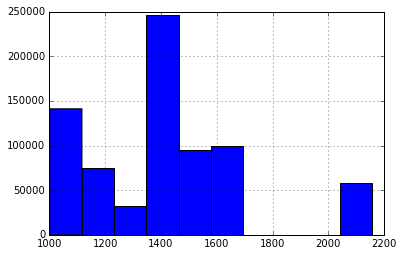

In [17]:
# del df
import gc
gc.collect()

309

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [23]:
rf = RandomForestRegressor(n_estimators=50, max_features=1.0,min_samples_split=3,n_jobs=4)
kf = KFold(y.shape[0],n_folds=5,random_state=401)

for (train, test) in kf:
    rf.fit(x[train], y[train])
    y_pred = rf.predict(x[test])
#     print(cross_val_score(rf,x,y,n_jobs=4))
    print(mean_squared_error(y[test], y_pred))

19.7053270666
19.4116895288
29.7252265481


KeyboardInterrupt: 

In [20]:
# print(mean_squared_error(y[train], y_pred))

In [21]:
%who

KFold	 RandomForestRegressor	 aux	 chunksize	 cols	 cross_val_score	 df	 df_fabricante	 df_producto	 
df_townstate	 gc	 kf	 mean_squared_error	 np	 pd	 reg	 rf	 test	 
train	 x	 y	 y_pred	 
